# Test of ADMM + DnCNN
let's denoise sar image.
using CNN as a step of the ADMM

In [1]:
import scipy
import numpy as np
import tensorflow as tf
from model import denoiser
from utils_train import *
import scipy.misc
import matplotlib.pyplot as plt
import imz2mat
import utils
import ADMM
%matplotlib inline

In [2]:
# This function is now in utils
def debiased(L):
    return np.log(L)-scipy.special.digamma(L)

In [3]:
# We then run a session tf(WARNING : execute once)
# Don't forget to close
sess = tf.Session()
model = denoiser(sess, sigma=25, add_noise=False)

[*] Initialize model successfully...


/cluster/storage/shorache/.conda/envs/bestenv/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


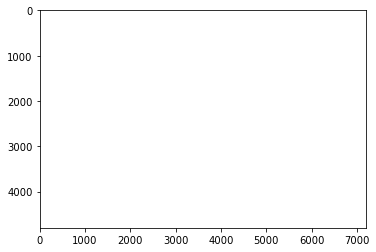

In [4]:
img = scipy.misc.imread("data/test/test.png")
plt.imshow(img)

imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imf
image en .imf
('image en float', 1024, ' ', 1024, '  canaux:', 1, ' verif : ', 0)
('lecture de ', 'data/PileSaintGervais_moyennearithmetique.imf', ' en quelconque', 1024, 1024, 1, ' offset ', 0, '>f', 4, ' complex', 0, 'blocksize', 4194304)
Données réelles. Nouvelle version de imz2mat  >f
38975.2394851


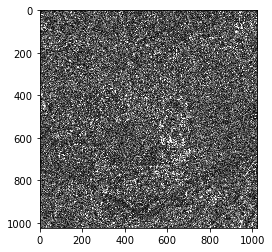

In [5]:
# load the ground truth
img_gt = imz2mat.imz2mat('data/PileSaintGervais_moyennearithmetique.imf')[0].astype(np.float32)
L=1
img_speckle = utils.addSARnoise(img_gt, L=L)


# psnr very low
img_gt_log = np.log(1+img_gt)
#img_gt_log = utils.robust_scale(img_gt, normal=False).astype(np.float32)
#img_in = utils.robust_scale(img_speckle, normal=False).astype(np.float32)
img_in = np.log(1+img_speckle)
#im1 = imz2mat.imz2mat('data/SAINTGERVAIS/pilesaintgervaisF.ima')
#img_in = np.log(1+np.abs(im1[0][:,:,0])**2)
#print(cal_psnr(img_gt_log, img_in))
print(cal_mse(np.exp(img_gt_log)-1, np.exp(img_in)-1))
utils.displayRSO(np.sqrt(img_speckle))


In [97]:
# load the weights here for sigma=25
ckpt_dir = "./checkpoint"
model.load(ckpt_dir)

[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint/DnCNN-tensorflow-88600


(True, 88600)

9151.85748298


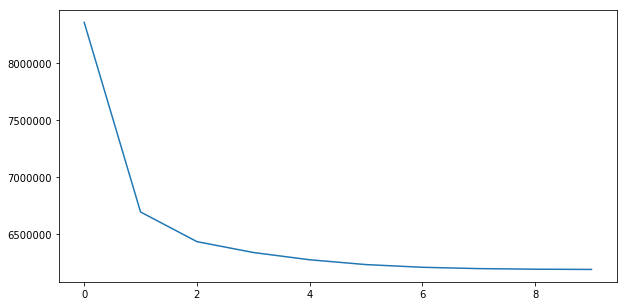

In [7]:
# Test admm alone
out, E = ADMM.ADMM(img_in, beta = 0.7,lamb = 1,niter = 10)
plt.figure(figsize=(10,5))
plt.plot(E)
#out = out + debiased(L)
#print(cal_psnr(img_gt_log, out))
print(cal_mse(np.exp(img_gt_log)-1, np.exp(out)-1))

In [8]:
# Test DnCNN
C = np.max(img_in)-np.min(img_in)
b = img_in.min()/C
img_inp = img_in/C - b
img_input = img_inp.reshape(1, img_in.shape[1], img_in.shape[0],1)
out2, _, _ = model.denoise(img_input)
out2 = out2.reshape(img_in.shape)
out2 = C*(out2+b)
out2 = out2 + debiased(L)
print(cal_mse(np.exp(img_gt_log)-1, np.exp(out2)-1))

9190.42110072


In [102]:
def visu_prior(input_img, n_iter=10):
    new_out20 = input_img.copy()
    for _ in range(n_iter):
        out20 = new_out20
        C = np.max(out20)-np.min(out20)
        b = out20.min()/C
        img_inp = out20/C - b
        img_input = img_inp.reshape(1, out20.shape[1], out20.shape[0],1)
        new_out20, _, _ = model.denoise(img_input)
        new_out20 = new_out20.reshape(img_in.shape)
        new_out20 = C*(new_out20+b)
        # print(np.linalg.norm(new_out20-out20))
    return new_out20



In [108]:
# what happens if we apply iteratively a CNN.
rectangle = np.zeros(img_in.shape)
rectangle[100:500, 200:300] = 1
fisher = np.log(1+utils.addSARnoise(np.ones(img_in.shape)))
list_img=[]
name = []
list_img.append(img_in.copy())
name.append('in')
list_img.append(img_gt_log.copy())
name.append('gt')
list_img.append(25*np.random.rand(*img_in.shape))
name.append('unif')
list_img.append(fisher)
name.append('fisher')
list_img.append(75*np.random.rand(*img_in.shape))
name.append('gauss')
list_ckp=["./checkpoint","./checkpoint_sar", "./checkpoint_sar_1/"]
name_ckp=['nat', 'sar', 'weak_sar']
for ind, img in enumerate(list_img):
    plt.imsave('data/test/{0}.png'.format(name[ind]), img, cmap='gray', dpi=1200)#gt
    print(ind)
    out20 = img.copy()
    for j in range(len(list_ckp)):
        model.load(list_ckp[j])
        out20 = img.copy()
        for i in range(10):
            out20 = visu_prior(out20, n_iter=1)
            path = 'data/test/{0}_{1}.png'.format(name[ind],name_ckp[j]+str(i))
    
            if(ind<2):
                utils.displayRSO(np.sqrt(np.exp(out20)-1), is_display=False,path=path)
            else:
                plt.imsave(path,out20, cmap='gray',dpi=1200)


    

0
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint/DnCNN-tensorflow-88600
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint_sar/DnCNN-tensorflow-50650
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint_sar_1/DnCNN-tensorflow-50650
1
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint/DnCNN-tensorflow-88600
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint_sar/DnCNN-tensorflow-50650
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint_sar_1/DnCNN-tensorflow-50650
2
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint/DnCNN-tensorflow-88600
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint_sar/DnCNN-tensorflow-50650
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint_sar_1/DnCNN-tensorflow-50650
3
[*] Reading checkpoint...


-0.0388272
0.28964


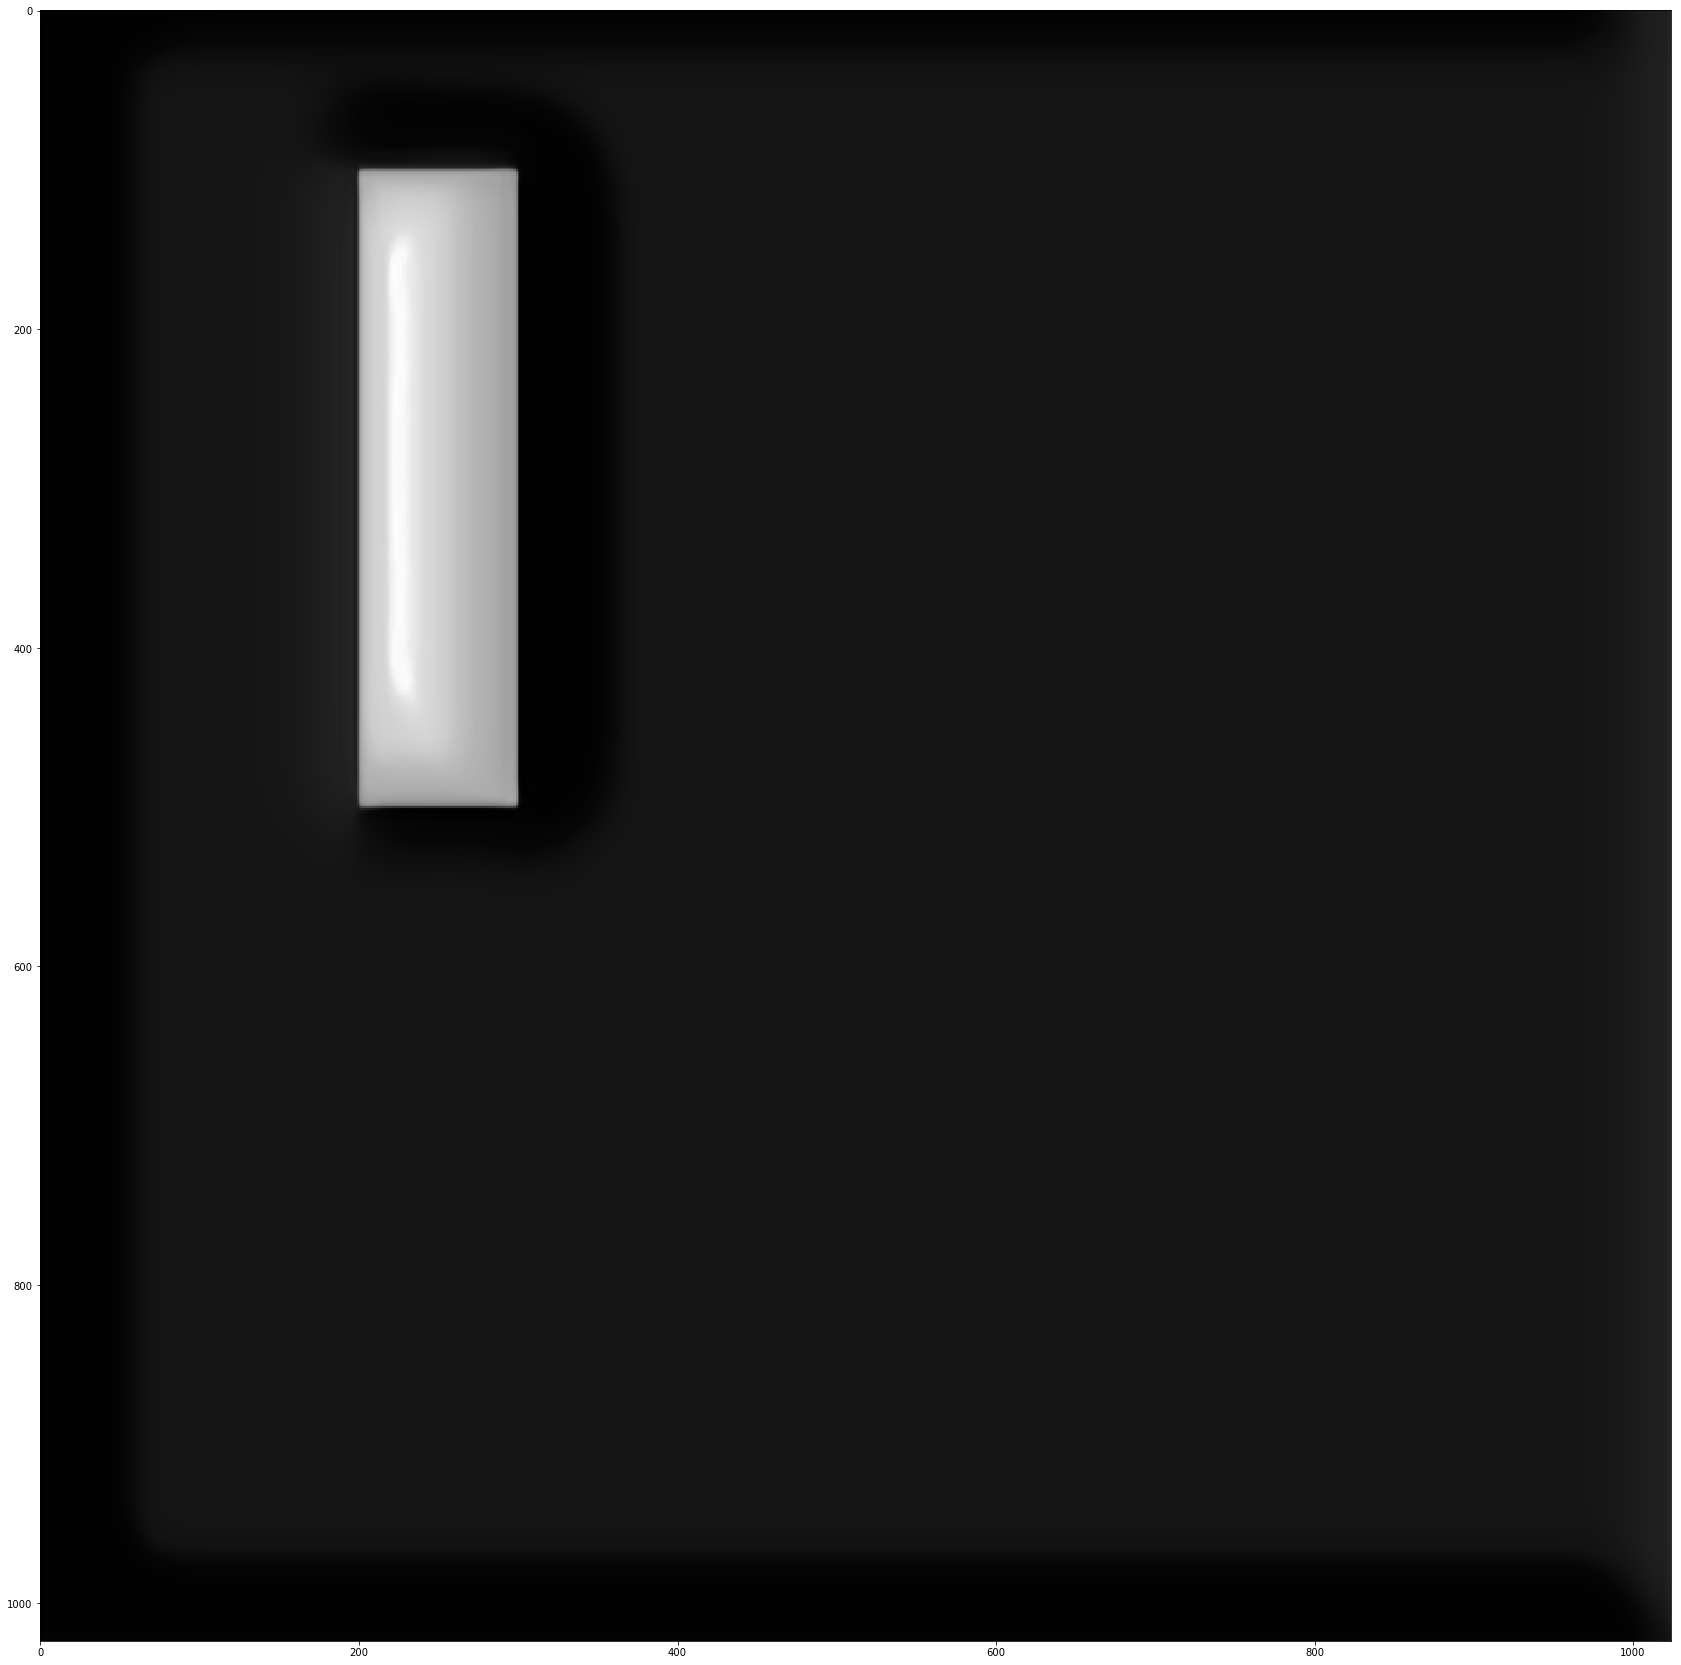

In [87]:
plt.figure(figsize=(30,30))
#plt.subplot(121)
#utils.displayRSO(np.sqrt(np.exp(out20)-1), is_display=True,path='data/test/new_exp_rec_sar.png')
plt.imshow(out20, cmap='gray')
print(out20.mean())
print(out20.std())
#plt.colorbar()

10067.5854767


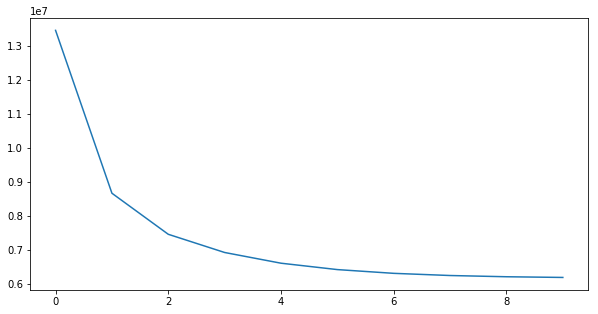

In [10]:
# We mixed both
out3, E = ADMM.ADMM(img_in, beta = 4,lamb = 1,niter = 10,L=L, CNNprior=model)
plt.figure(figsize=(10,5))
plt.plot(E)
#out3 = out3 + debiased(L)
print(cal_mse(np.exp(img_gt_log)-1, np.exp(out3)-1))

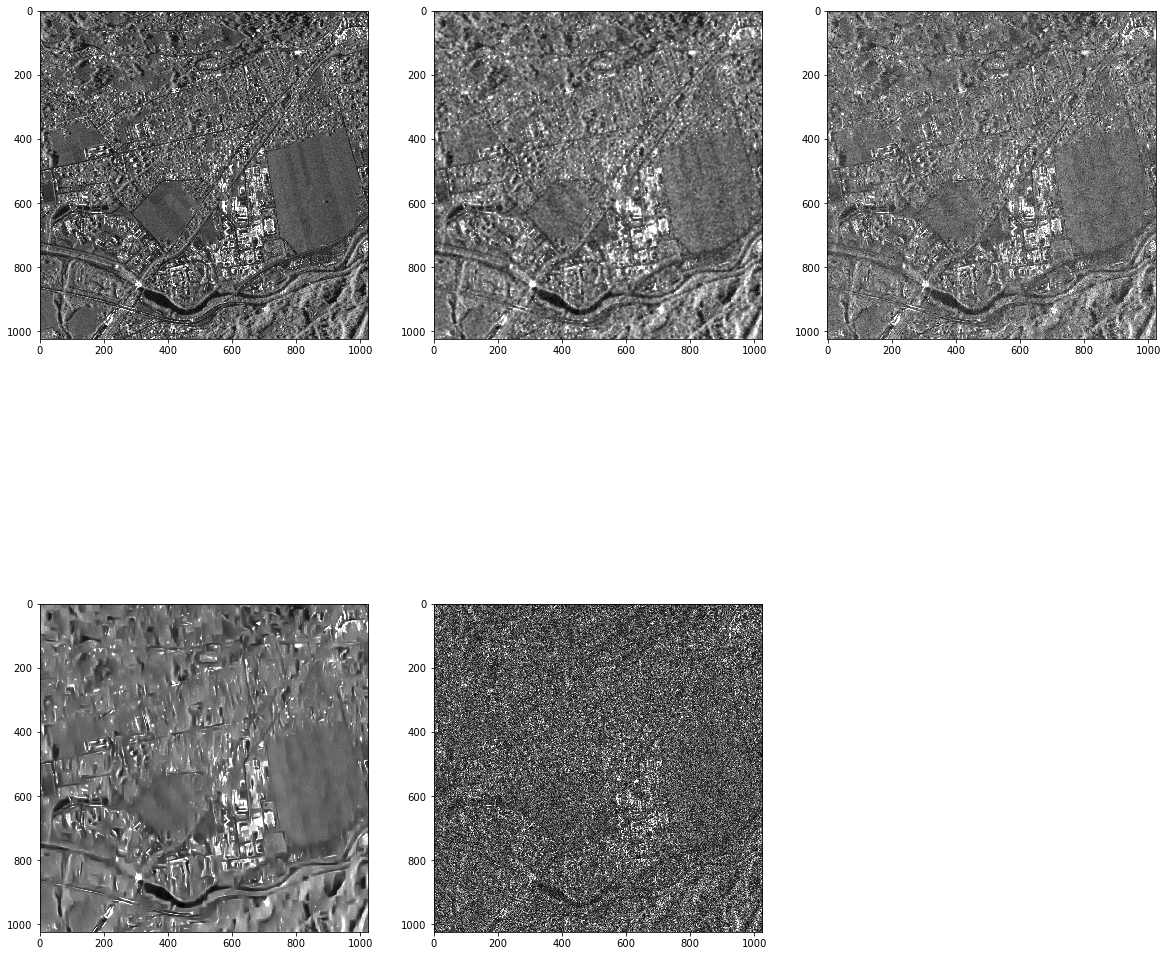

In [11]:
#display the result
plt.figure(figsize=(20,20))
plt.subplot(231)
utils.displayRSO(np.sqrt(np.exp(img_gt_log)-1))
plt.subplot(232)
utils.displayRSO(np.sqrt(np.exp(out)-1))
plt.subplot(233)
utils.displayRSO(np.sqrt(np.exp(out2)-1))
plt.subplot(234)
utils.displayRSO(np.sqrt(np.exp(out3)-1))
plt.subplot(235)
utils.displayRSO(np.sqrt(np.exp(img_in)-1))

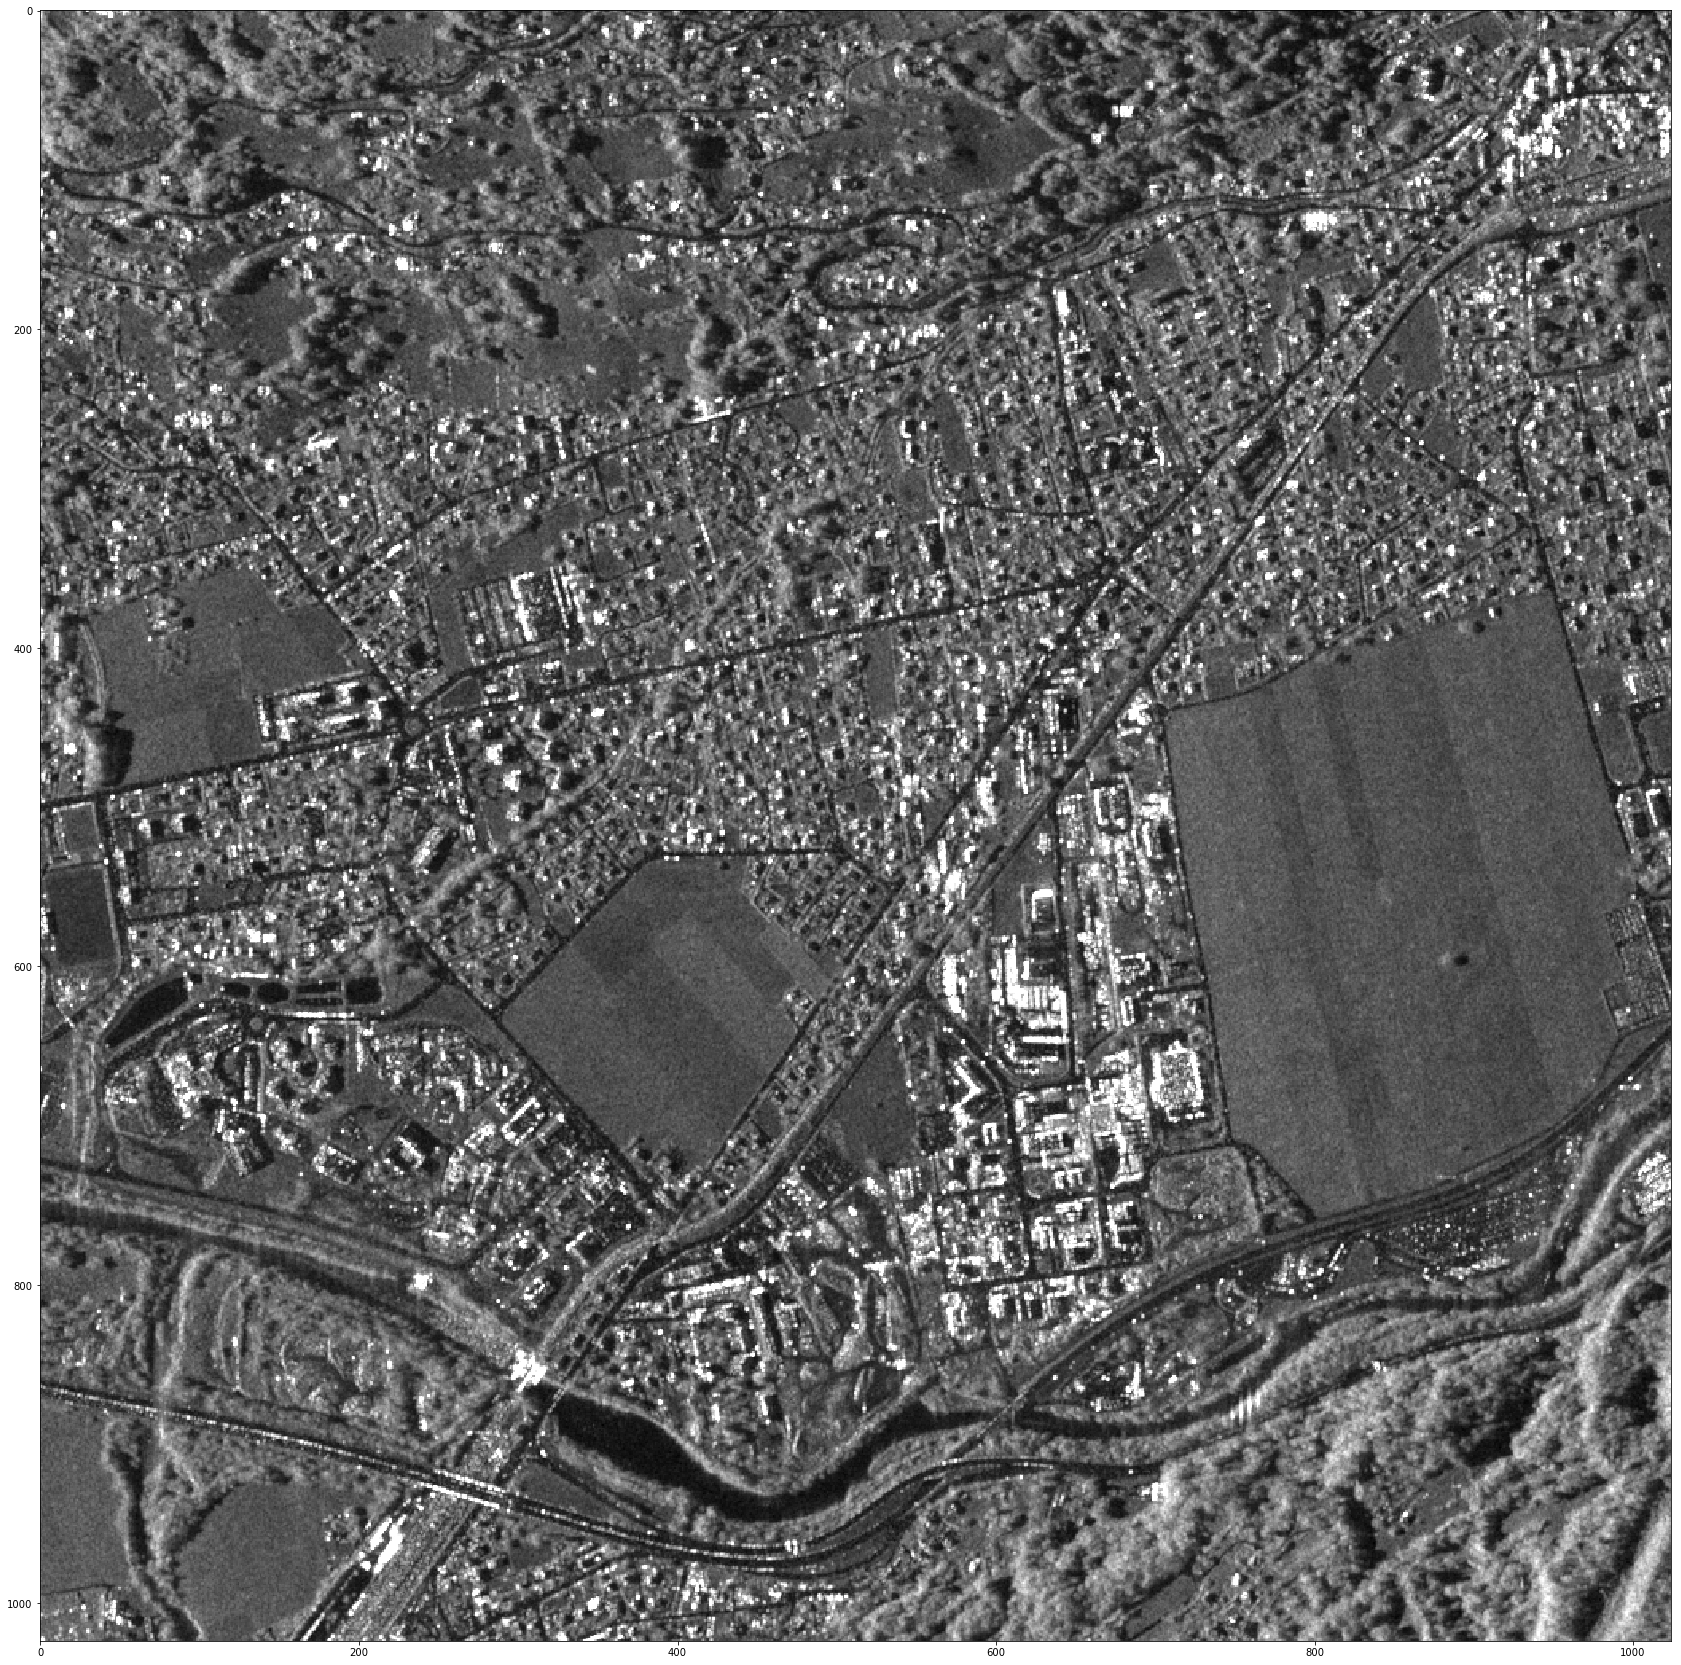

In [96]:
plt.figure(figsize=(30,30))
#plt.subplot(121)
utils.displayRSO(np.sqrt(np.exp(img_gt_log)-1))

#plt.subplot(122)
#utils.displayRSO(np.sqrt(np.exp(out)-1))

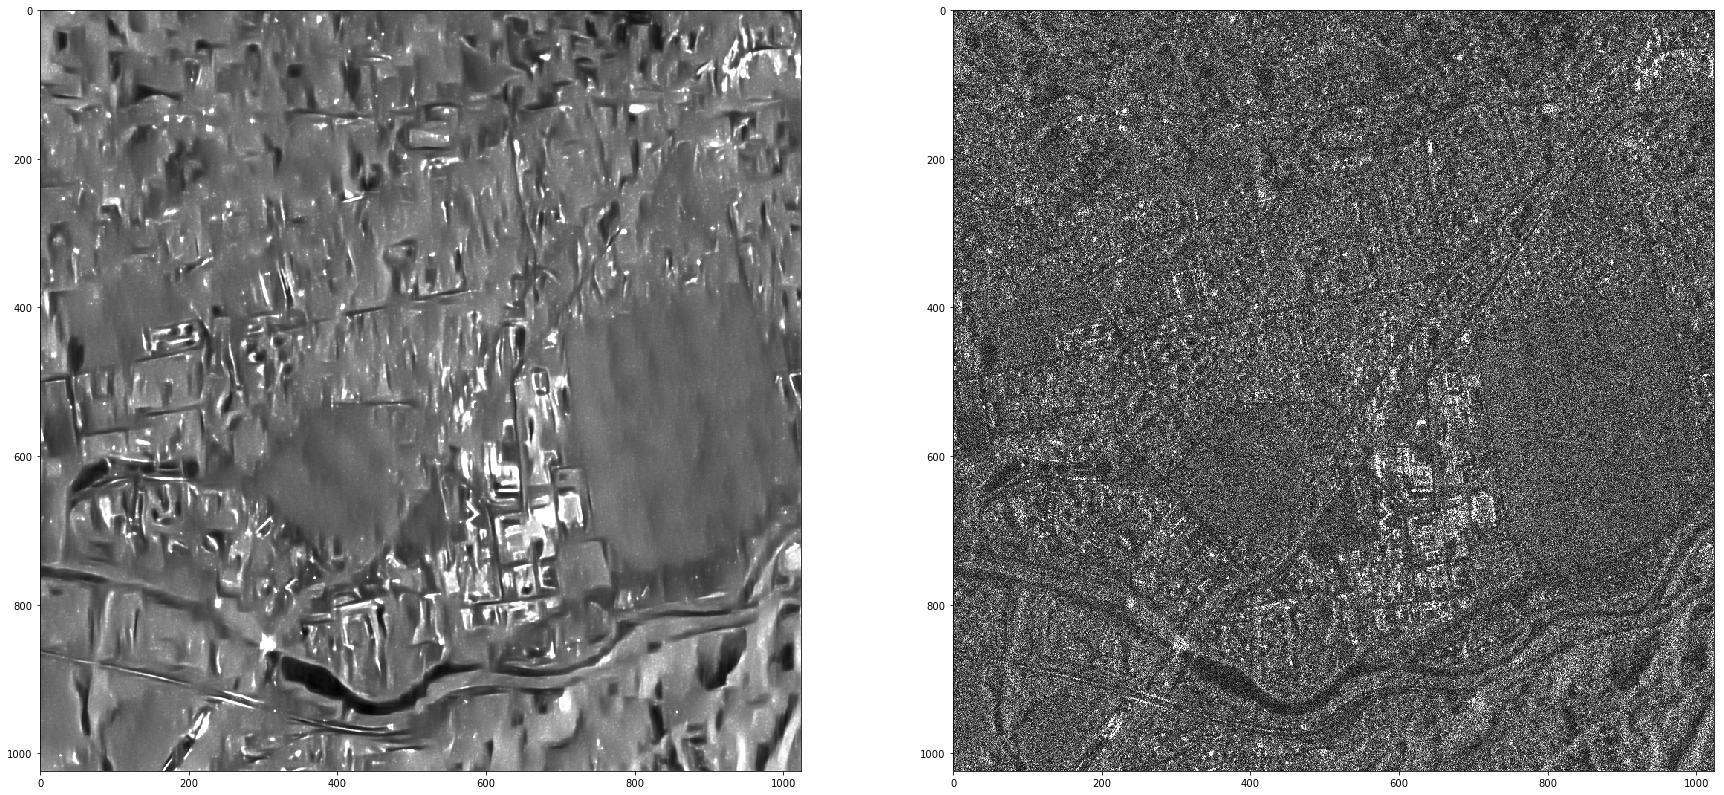

In [13]:
plt.figure(figsize=(30,30))
plt.subplot(121)
utils.displayRSO(np.sqrt(np.exp(out3)-1))
plt.subplot(122)
utils.displayRSO(np.sqrt(np.exp(img_in)-1))

In [14]:
print(scipy.special.polygamma(3,1))
u = np.exp(out3)-1
print(u[400:600, 800:1000].mean())
print(u[400:600,800:1000].std())
print(img_gt[400:600,800:1000].mean())
print(img_gt[400:600,800:1000].std())
#sess.close()

6.49393940227
94.3766415955
12.6814778604
109.697
34.2743
